
# Imports

In [1]:
import numpy as np
from math import ceil

import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt

%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (20, 6)

#habilita el zoom
# import mpld3
# mpld3.enable_notebook()

# Load audio

El audio que estoy usando es Smell like teen spirit de Nirvana

Características:
* Monocanal
* Frecuencia de muestreo: 22050Hz
* Profundidad: 16bits


In [2]:
from scipy.io import wavfile
sampleRate, audioData = wavfile.read("data/sound/smell.wav")

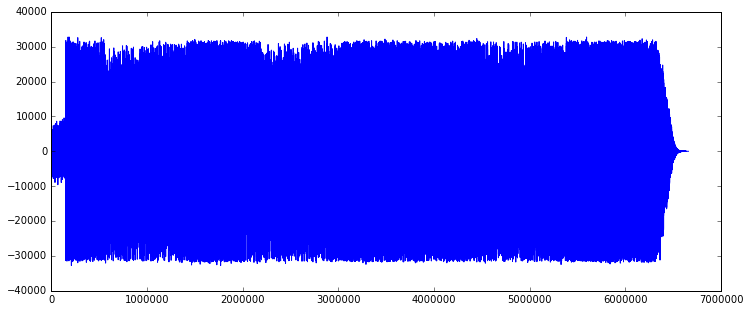

In [31]:
%matplotlib inline
plt.figure(figsize=(12, 5))
plt.plot(audioData)
plt.show()

# Data prep 

Elijo el tamaño de mis muestras de audio y preparo la matriz a utilizar

In [15]:
#SEGUNDOS_FILA = 0.2
SEGUNDOS_FILA = 2

print("Tomando",SEGUNDOS_FILA,"segundos")
print("Llenando de silencio al final para que me quede cortable...")

newDataSize = audioData.size
while newDataSize % sampleRate != 0:
    newDataSize += 1
    
segundos = newDataSize / sampleRate

while newDataSize % (sampleRate*SEGUNDOS_FILA) != 0:
    newDataSize += sampleRate

# print("new size:", newDataSize)
print("Longitud (s) de la cancion:", newDataSize / sampleRate)

audioData.resize(newDataSize)

#lo paso a matriz, tipo dataset
matrixAudioData = audioData.reshape( ( int(newDataSize/ (sampleRate*SEGUNDOS_FILA) ), int(sampleRate * SEGUNDOS_FILA) ))
print("shape de la matriz de audio crudo:", matrixAudioData.shape)


Tomando 2 segundos
Llenando de silencio al final para que me quede cortable...
Longitud (s) de la cancion: 302.0
shape de la matriz de audio crudo: (151, 44100)


# Principal Component Analysis

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200) #asi explicaba 95%
# pca = PCA(n_components=22050)
pca.fit(matrixAudioData)
print("Variance explained:", pca.explained_variance_ratio_.sum())
matrixAudioDataTransformed = pca.transform(matrixAudioData)
# print(matrixAudioDataTransformed[0])
print("shape transformed:", matrixAudioDataTransformed.shape)

Variance explained: 1.0
shape transformed: (151, 151)


# Cluster Jerárquico

In [17]:
from scipy.cluster import hierarchy as h
from scipy.spatial import distance as dist

distanceFunction = 'canberra'
linkageType = 'average'

distanceMatrix = dist.pdist(matrixAudioDataTransformed, distanceFunction) #canberra (0.8), cityblock (0.76), braycurtis(0.77)
clusters = h.linkage(distanceMatrix, linkageType)


c,d=h.cophenet(clusters, distanceMatrix) #factor cofonético
print("distancia:",distanceFunction)
print("linkage:",linkageType)
print("cofonetica:",c)

distancia: canberra
linkage: average
cofonetica: 0.89850577735


### Dendograma

In [20]:
#THRESHOLD = 149
THRESHOLD = 111.5

cutTree = h.cut_tree(clusters, height= THRESHOLD)
# minutos = 0
# segundos = 0
# for label in cutTree:
#     print(str(minutos) + ":" + str(segundos), str(label))
#     segundos += SEGUNDOS_FILA
#     if ( segundos >= 60 ):
#         minutos += 1
#         segundos -= 60

# print(clusters.shape)
# print(clusters)
# exit()

#matrixAudioDataAndCluster = np.hstack((matrixAudioDataTransformed, cutTree))

cantClusters = np.unique(cutTree).size
print("Cantidad de clusters:", cantClusters)

Cantidad de clusters: 3


<IPython.core.display.Javascript object>


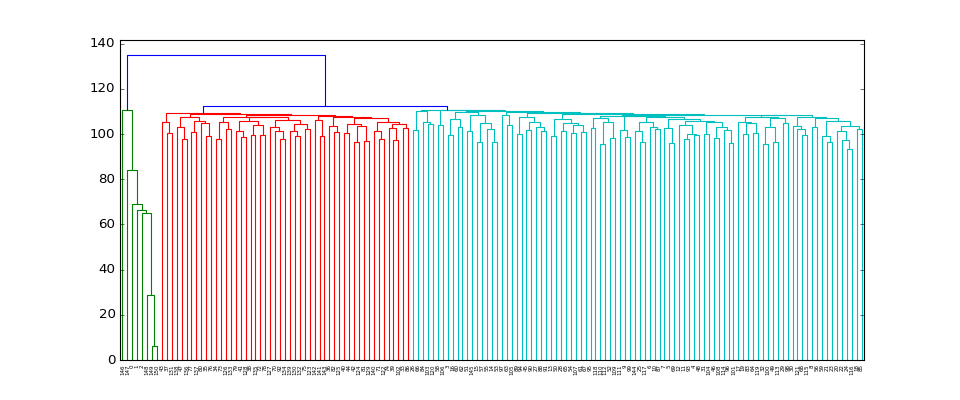

In [21]:
plt.figure(figsize=(12, 5))
dn = h.dendrogram(clusters, color_threshold = THRESHOLD)
plt.show()

### Histograma

<IPython.core.display.Javascript object>


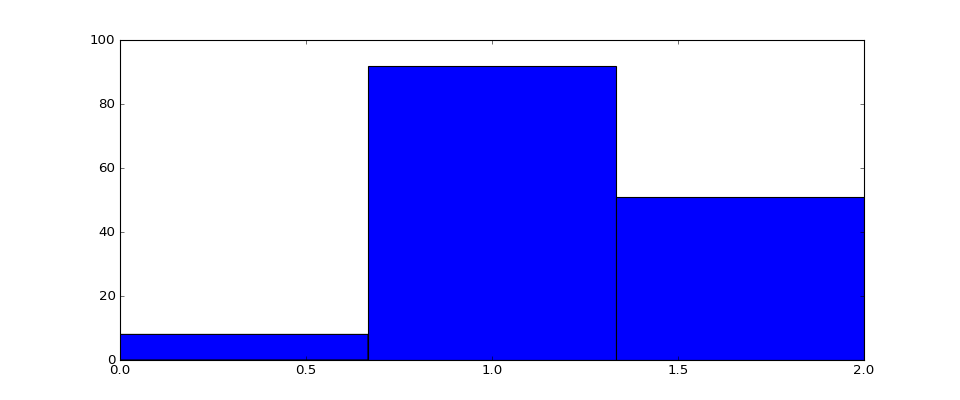

Count:
[  8.  92.  51.]


In [22]:
plt.figure(figsize=(12, 5))
n = plt.hist(cutTree, bins=cantClusters)[0]
plt.show()
print("Count:")
print(n)

# Multi-dimensional scaling

In [23]:
#check http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html

from sklearn.manifold import MDS 
from sklearn.metrics import pairwise_distances

#similarities = pairwise_distances(matrixAudioDataTransformed, metric = distanceFunction, n_jobs = -1)
similarities = pairwise_distances( dist.squareform(distanceMatrix), n_jobs = -1)

mds = MDS(n_components=2, dissimilarity="precomputed", n_jobs=-1) #max_iter=3000, eps=1e-9, 
positions = mds.fit(similarities).embedding_
#positions = mds.fit(distanceMatrix).embedding_
print("Positions shape:", positions.shape)

Positions shape: (151, 2)


### Scatterplot

<IPython.core.display.Javascript object>


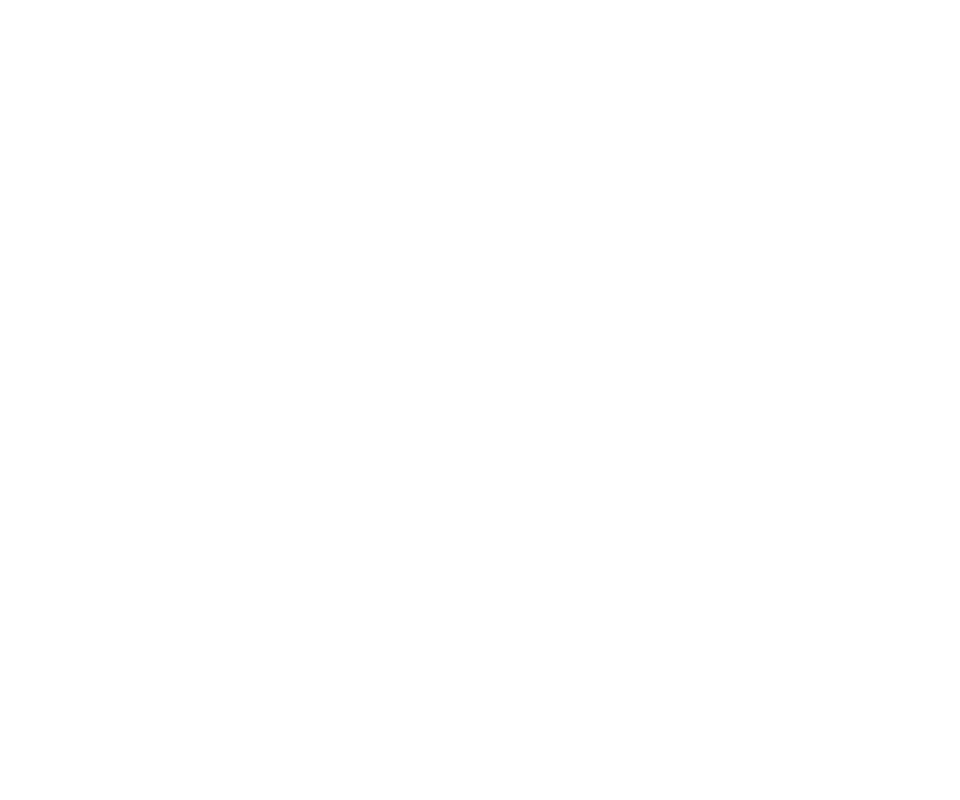

In [24]:
# para debuggear
#
# import sys
# nb_stdout = sys.stdout
# sys.stdout = open('/dev/stdout', 'w')

%matplotlib notebook

import sounddevice as sd

def pointClicked(event):
    sound = None
    
    if ( event.xdata == None ):
        return
    
    for i in range(0, positions.shape[0]):
        if dist.euclidean( positions[i,:], np.array( (event.xdata,event.ydata) ) ) < 10:
            sound = matrixAudioData[i]
            
    if sound != None:
        sd.play(sound, 22050, blocking = True)

fig = plt.figure(figsize=(12, 10))
plt.scatter(positions[:,0], positions[:,1], s=60, c=cutTree)
fig.canvas.mpl_connect('button_press_event', pointClicked )             
plt.show()

# CSV export

Armo un csv con el audio, el x e y y el número de cluster

In [11]:
import csv

outCsv = np.hstack((positions, cutTree))

